# A beginner-friendly implementation of the VQE with qiskit 1.0 (Part 3)

## Introduction

In the previous Notebooks we learned how to implement VQE from its very scratch for a really simple Hamiltonian. We also learned how to implement the _gradient descent method_ in order to find the optimum set of parameters to our problem. However, this costed us so many lines of code, and now I must tell you the truth: `qiskit` ans `scipy` can make our lives really easier!!

In this Notebook I will show you a more sofisticated way of implementing the VQE. This is actually the "advanced" way in qiskit, but don't worry: now you know the basics! This means that (hopefully) it will be a lot easier to you to know what's going on behind the scenes of our functions.

## Previous Notebooks

Let me summarize what we did previously.

We were given a Hamiltonian $H$ and asked to return its lowest (or "ground-state") expectation value, $\langle H \rangle_0$. To this end, of course, we had to determine its ground state eigenvector. Our strategy was then to create a parameterized quantum circuit, i.e. an _ansatz_, and vary its state until we find the state that produces the lowest $\langle H \rangle$.

In the specific cases considered ($H = Z$ and $H = Z - X$) things were very simple, but if $H$ becomes really complicated, a best practice is to find what we call a _scalable_ method. That is, a code implementation in which we can simply change a few code parameters and the code line defining $H, and the code will run as well, whatever our choice is.

Of course, scalability is not always possible, but fortunatelly, in our case, it is. Nonetheless, I need first to introduce you the `Estimator` primitive.

## Optimization Loop

A major feature of `qiskit 1.0x` is the use of _primitives_, which are the basic operations a quantum computer can perform. In summary, there are 2 of them, the `Sampler`, which is used to obtain the probability distribution of a statevector, and the `Estimator`, which is used to easily compute expectation values of observables. In this Notebook I will introduce only the `Estimator` and you can read more about the `Sampler` here (ADD LINK).

### Simpler example

#### Defining the Hamiltonian and the Ansatz

Let us try to be shorter this time and begin our hands-on work right now. I will consider first the same Hamiltonian as in the last Notebook.

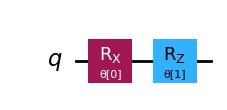

In [25]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector, QuantumCircuit

## Hamiltonian
H = SparsePauliOp(data = ["X", "Z"], coeffs = [1, -1])

## Ansatz
num_qubits = 1 # We need only one qubit (see Notebook 2)
theta = ParameterVector("θ", 2) # We need only two parameters (see Notebook 2)
ansatz = QuantumCircuit(num_qubits)
ansatz.rx(theta[0], 0)
ansatz.rz(theta[1], 0)
ansatz.draw("mpl")

#### Calling `Estimator`

Now that we have our Hamiltonian and our ansatz, we can use `StatevectorEstimator` to compute expectation values as we vary our parameters.

In [40]:
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()

Now it will be proven very useful to define a function that computes the expectation value of our Hamiltonian. Note that the `job` called with `Estimator` requieres as argument a tuple of PUBs (Primitive Unitary Blocks) containing the ansatz and the observable for which we want to compute the expectation value.

In [44]:
def energy_exp(params, ansatz, hamiltonian, estimator):
    '''
    params: list of parameters to be assigned to the ansatz
    hamiltonian: Hamiltonian of the system
    ansatz: Parameterized quantum circuit
    estimator: an instance of the Estimator primitive (in our case it is Estimator alongside AerSimulator)
    '''
    
    pubs = (ansatz, hamiltonian, params)
    job = estimator.run([pubs])
    exp_val = job.result()[0].data.evs

    return exp_val

#### Optimizing with `scipy`

The optimization part of our process took us several lines of code. However, the `minimize` function from scipi can do all the dirty job of finding the optimum set of parameters for us with a single line of code!

In [56]:
import numpy as np
from scipy.optimize import minimize

x0 = np.ones(2) ## Initial guess for the parameter list: [1, 1]

result = minimize(energy_exp, x0, args = (ansatz, H, estimator), method = "BFGS")
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.4142135623362644
        x: [-7.854e-01  1.571e+00]
      nit: 8
      jac: [-9.716e-06 -2.205e-06]
 hess_inv: [[ 6.560e-01 -2.372e-02]
            [-2.372e-02  1.404e+00]]
     nfev: 27
     njev: 9

We passed the `"BFGS"` method as the argument of the minimize function, which is a gradient-based method similar to the gradient descent method. There are, however, several other optimization techniques, like global optimization. You can check more about this here and here.

Now let us break down the outputs above.

- `message`: Status of the optimization (returns an error message if somethings goes wrong)
- `sucess`: `True` for sucess, `False` for Fail
- `status`: `0` indicates that the optimization terminated successfully
- `fun`: This is the minimum value found by the optimizer.
- `x`: The list of optimal parameters
- `nit`: Number of iteractions the optimizer performed to get the solution
- `jac`: The gradient (Jacobian) of the function we are trying to minimize
- `hess_inv`: The inverse of the Hessian matrix, which can be used to estimate the degree of uncertainty in the optimization process
- `nfev`: Number of times the optimizer needed to evaluate the function
- `njev`: Number of times the optimizer needed to evaluate the gradient of the function

You can check that all the answer are consistent with our previous Notebook. The ground-state energy is, as expected, $E_0 \approx \sqrt{2} = -1.4142$ and below we print our groud state eigenvector:

### More complex example

As said earlier, the method presented extends very simply to more complex Hamiltonians. For example, take
\begin{equation}
    H = - \frac{1}{2} I \otimes X \otimes X - \frac{1}{2} Z \otimes Z \otimes I.
\end{equation}

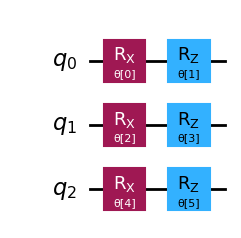

In [70]:
## New Hamiltonian
new_H = SparsePauliOp(data = ["XXI", "ZZI"], coeffs = [-1/2, -1/2]) # Recall that qiskit uses reversed qubit ordering

## New ansatz
new_ansatz = QuantumCircuit(3) # Now we need 3 qubits

new_theta = ParameterVector("θ", 6) # 2 parameters for each qubit

new_ansatz.rx(new_theta[0], 0)
new_ansatz.rz(new_theta[1], 0)

new_ansatz.rx(new_theta[2], 1)
new_ansatz.rz(new_theta[3], 1)

new_ansatz.rx(new_theta[4], 2)
new_ansatz.rz(new_theta[5], 2)

new_ansatz.draw("mpl")

In [66]:
## Optimization Loop
x0 = np.ones(6) ## Initial guess for the parameter list: [1, 1]

new_result = minimize(energy_exp, x0, args = (new_ansatz, new_H, estimator), method = "BFGS")
new_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.499999999995433
        x: [ 1.000e+00  1.000e+00  8.019e-01  1.571e+00  8.019e-01
             1.571e+00]
      nit: 4
      jac: [ 1.490e-08  7.451e-09  1.490e-08 -1.065e-06  1.490e-08
            -1.073e-06]
 hess_inv: [[ 1.000e+00 -2.366e-12 ...  6.159e-07 -2.734e-06]
            [-2.366e-12  1.000e+00 ...  3.573e-07 -1.482e-06]
            ...
            [ 6.159e-07  3.573e-07 ...  1.124e+00 -4.310e-01]
            [-2.734e-06 -1.482e-06 ... -4.310e-01  2.427e+00]]
     nfev: 35
     njev: 5

In this example, the optimizer found $E_0 \approx -1/2$. We left printing the ground state eigenvector as an exercise.

## Closing remarks

In this Notebook we saw how to implement VQE in a scalable, more compact, and (why not saying?) elegant way. This is actually how it is implemented in most applications across industrial needs, and it has the advantage of the `scipy` minimizer doing all the dirty job for us very concisely and quickly.

It should be noted, however, that each application of VQE may come with its own subtleties. For example, a certain _global_ optimization method may be better suited for the problem you are considering. My intention here was simply to give you a quickstart to your journey. Hope this was achieved. Thank you!